# Introduction 
This python notebook will explore a dataset from the <code>Datasets</code> library in order to analyze top contributing factors to customers cancelling subscriptions to service as well as analyze the behaviourioul data of customers in order to idenitfy a pattern and train a model which can identify customers that are likely to leave the company or stop using a product or service

In [1]:
!uv pip install bayesian-optimization

Audited 1 package in 12ms


In [2]:
# library importing
from datasets import load_dataset
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from hyperopt import fmin, tpe, hp

from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV

from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

In [3]:
# load dataset
dataset = load_dataset("scikit-learn/churn-prediction")

In [4]:
df = pd.DataFrame(dataset["train"])
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


## EDA 
Explore dataset and gain valuable insights

In [5]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
df.tail()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
7042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Most of the features are categorical data with some being binary data (example: PhoneService). 
This info gives us a good idea on the preprocessing steps that we will have to carry out later

In [8]:
(df.isnull().sum() / len(df)) * 100

customerID          0.0
gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64

No missing values, thats good !

In [9]:
df.iloc[0]

customerID                7590-VHVEG
gender                        Female
SeniorCitizen                      0
Partner                          Yes
Dependents                        No
tenure                             1
PhoneService                      No
MultipleLines       No phone service
InternetService                  DSL
OnlineSecurity                    No
OnlineBackup                     Yes
DeviceProtection                  No
TechSupport                       No
StreamingTV                       No
StreamingMovies                   No
Contract              Month-to-month
PaperlessBilling                 Yes
PaymentMethod       Electronic check
MonthlyCharges                 29.85
TotalCharges                   29.85
Churn                             No
Name: 0, dtype: object

binary data columns: gender, Partner, Dependants, PhoneService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, PaperlessBilling

These need to be encoded using one hot encoding 

In [10]:
# will need to convert this column to float64 data type since it was in object type initially (not sure why it was in object since these are clearly values)

# Replace empty or whitespace strings with NaN
df["TotalCharges"] = df["TotalCharges"].replace(r"^\s*$", np.nan, regex=True)

df["TotalCharges"] = df["TotalCharges"].astype(float)

In [11]:
df["TotalCharges"].isnull().sum()
# hmmm 11 null rows. can drop ?

11

In [12]:
df_copy = df.copy(deep=True)

array([[<Axes: title={'center': 'TotalCharges'}>]], dtype=object)

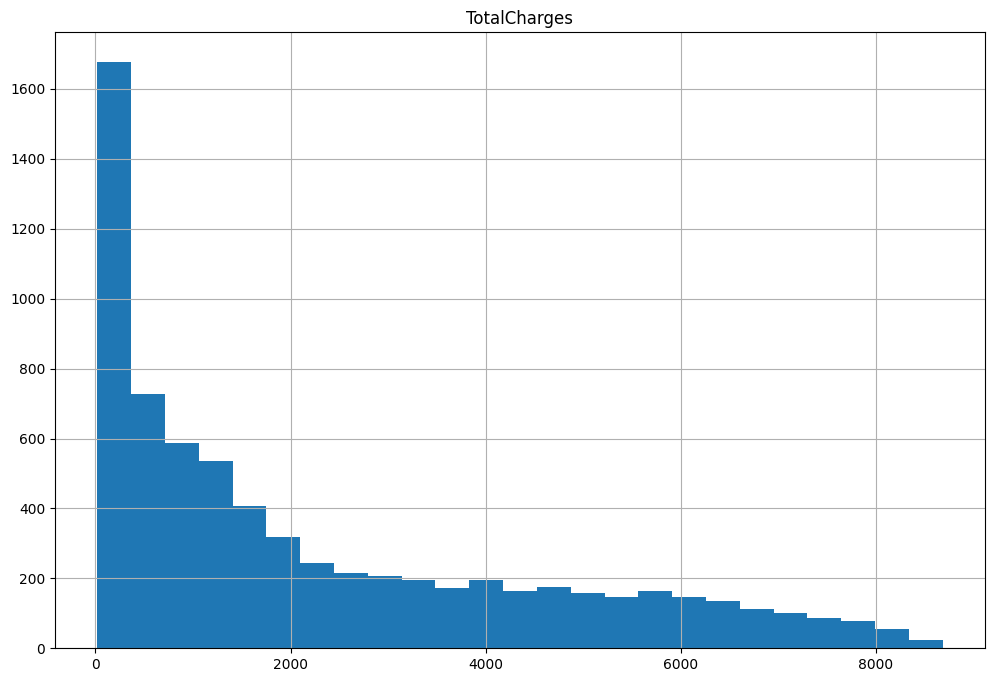

In [13]:
df_copy.hist(column="TotalCharges", bins=25, grid=True, figsize=(12, 8))

Dist skewed to the right. to fill up the NA vals we will do median imputation. However I might change this approach later on to just drop the NA value rows altogether

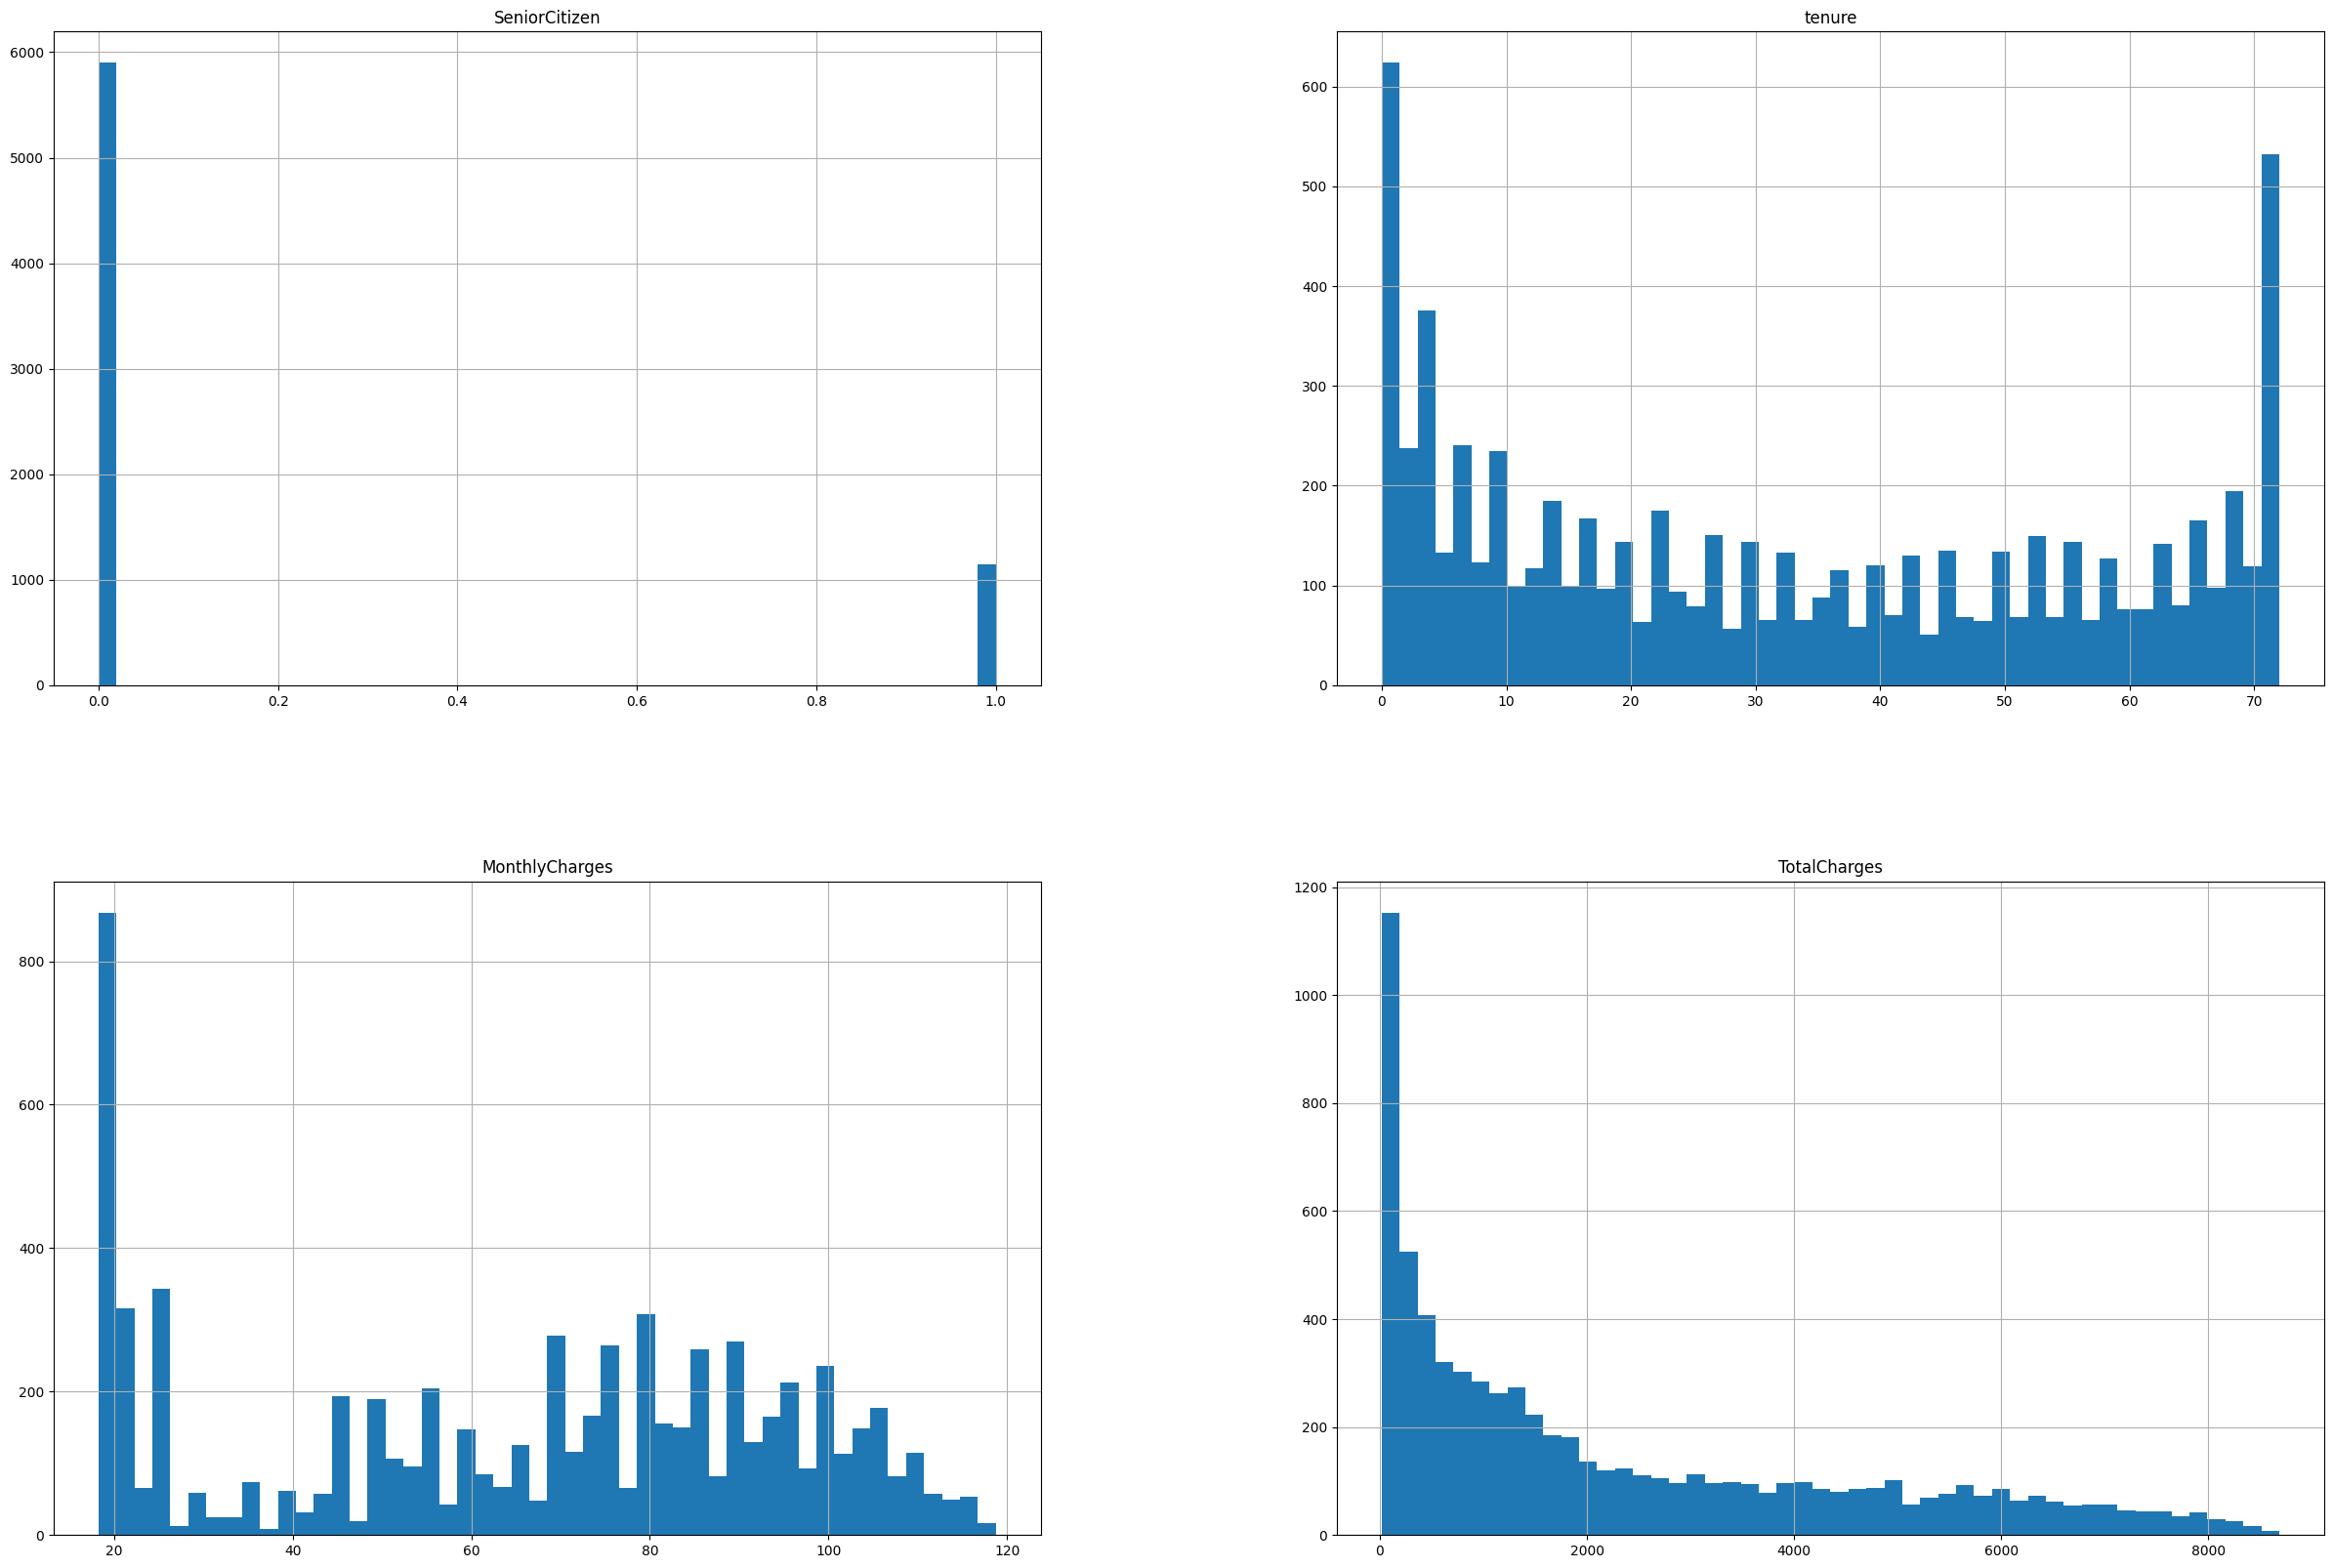

In [14]:
# charts for data distribution
df_copy.hist(bins=50, figsize=(30, 20))
plt.show()

'TotalCharges' has a distribution skewed to the right.  
MonthlyCharges skewed to the right  
'tenure' has a bimodal distributon with peaks on the extreme left annd right

<BarContainer object of 100 artists>

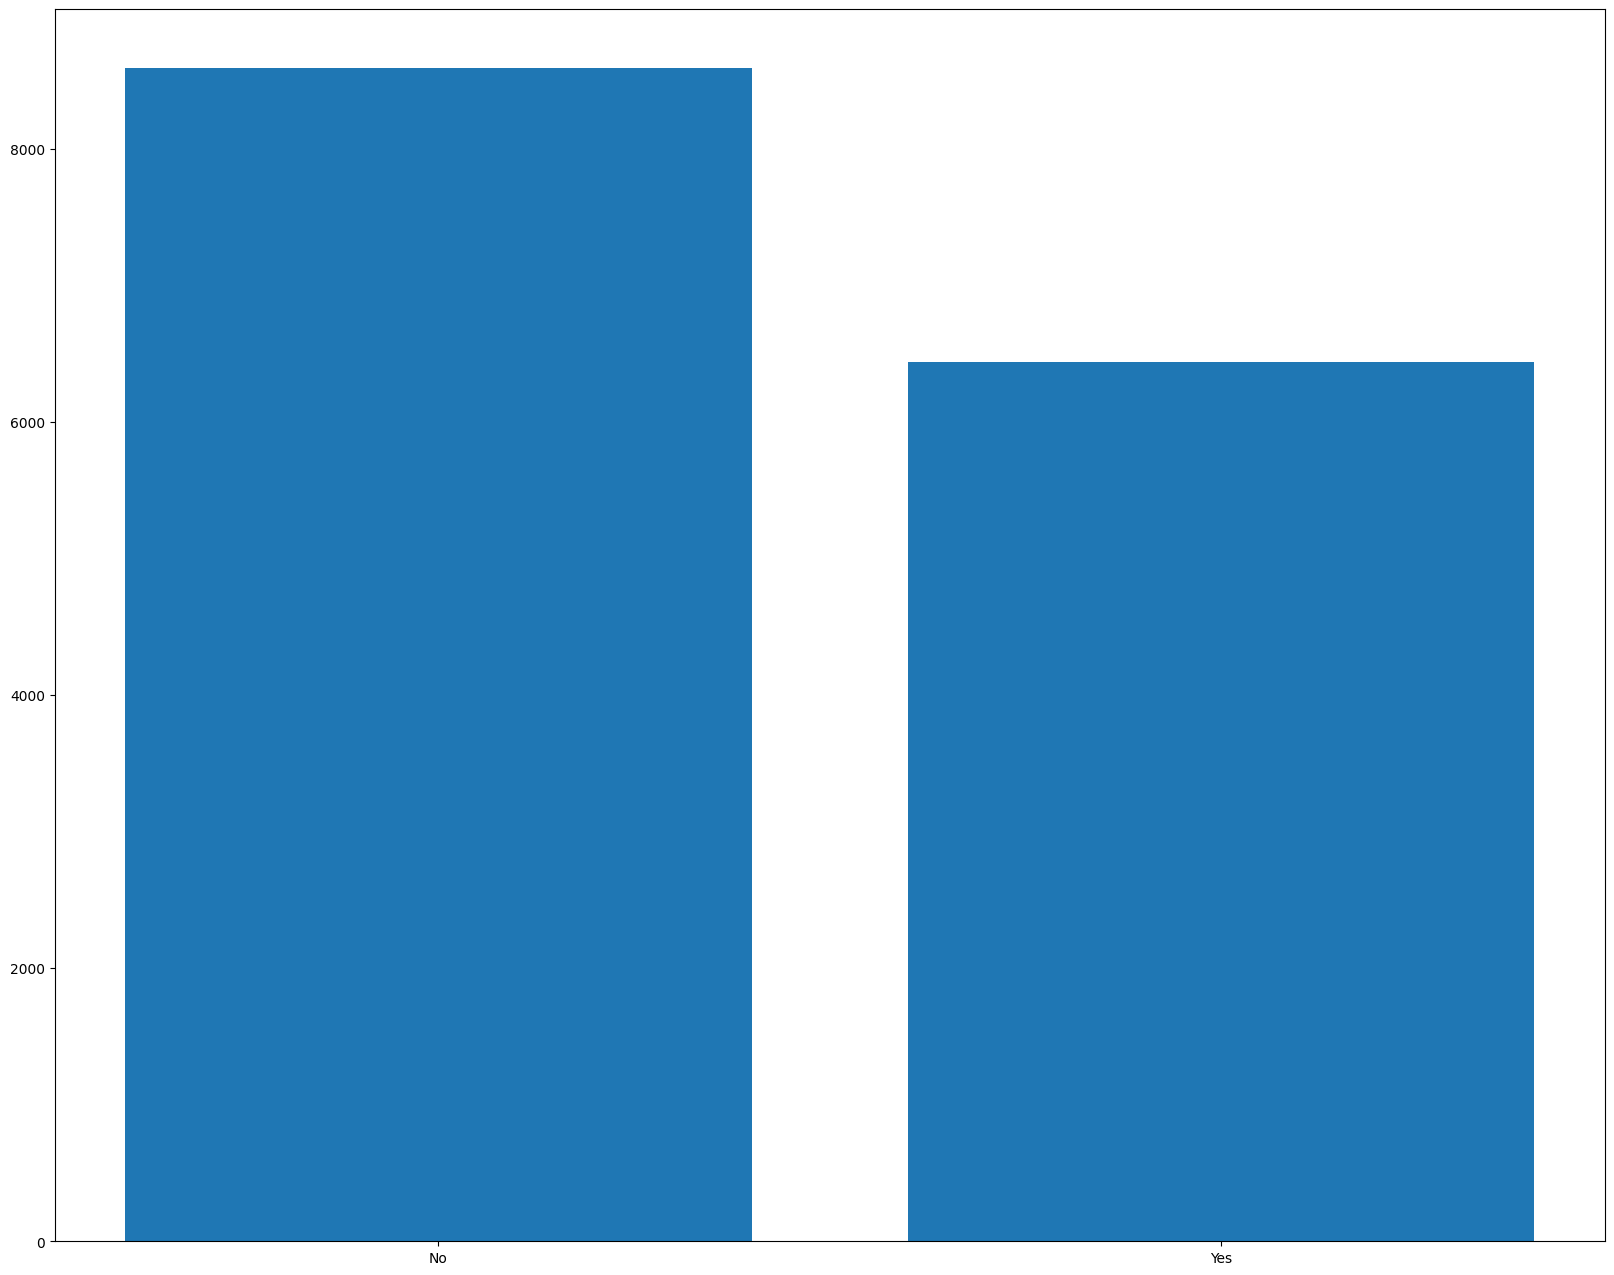

In [15]:
# how do charge features affect Churn

df_sam = df_copy.sample(n=100)
plt.figure(figsize=(20, 16))
plt.bar(df_sam["Churn"], df_sam["TotalCharges"])

In [16]:
# proportion of nos and yesses
(df_copy["Churn"].value_counts() / len(df_copy)) * 100

Churn
No     73.463013
Yes    26.536987
Name: count, dtype: float64

only 26.5 % of the records are for 'Yes'. we will need to carry out stratified sampling in order to get equal number of records so that the resulting model is unbiased

## Data Preprocessing 

### Encoding

#### Unique value count table 

In [17]:
# unique val count
unique_counts = (
    pd.DataFrame(df.nunique(), columns=["Unique_Values"])
    .reset_index()
    .rename(columns={"index": "Variable"})
)

unique_counts

,Variable,Unique_Values
0,customerID,7043
1,gender,2
2,SeniorCitizen,2
3,Partner,2
4,Dependents,2
5,tenure,73
6,PhoneService,2
7,MultipleLines,3
8,InternetService,3
9,OnlineSecurity,3


#### Binary Encoding

In [18]:
# binary encoding gender
df["gender"].value_counts()
df["gender"] = df["gender"].map({"Male": 1, "Female": 0})

#### One-Hot Encoding

In [19]:
# Internet Service
enc_InternetService = pd.get_dummies(df["InternetService"], prefix="IS", dtype=int)
df = pd.concat([df, enc_InternetService], axis=1)
df = df.drop("InternetService", axis=1)

# Contract
enc_Contract = pd.get_dummies(df["Contract"], prefix="Contract", dtype=int)
df = pd.concat([df, enc_Contract], axis=1)
df = df.drop("Contract", axis=1)

# PaymentMethod
enc_PM = pd.get_dummies(df["PaymentMethod"], prefix="PM", dtype=int)
df = pd.concat([df, enc_PM], axis=1)
df = df.drop("PaymentMethod", axis=1)

# MultipleLines
enc_MultipleLines = pd.get_dummies(df["MultipleLines"], prefix="ML", dtype=int)
df = pd.concat([df, enc_MultipleLines], axis=1)
df = df.drop("MultipleLines", axis=1)

#### Binary Encoding 
For data that is just 'Yes' or 'No'

In [20]:
# binary encoding all the binary data cols
bin_cols = [
    "Partner",
    "Dependents",
    "PhoneService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "PaperlessBilling",
]

for i in bin_cols:
    df[i] = df[i].map({"Yes": 1, "No": 0})

### Missing value filling

using median imputation

In [21]:
df.isnull().sum()

customerID                         0
gender                             0
SeniorCitizen                      0
Partner                            0
Dependents                         0
tenure                             0
PhoneService                       0
OnlineSecurity                  1526
OnlineBackup                    1526
DeviceProtection                1526
TechSupport                     1526
StreamingTV                     1526
StreamingMovies                 1526
PaperlessBilling                   0
MonthlyCharges                     0
TotalCharges                      11
Churn                              0
IS_DSL                             0
IS_Fiber optic                     0
IS_No                              0
Contract_Month-to-month            0
Contract_One year                  0
Contract_Two year                  0
PM_Bank transfer (automatic)       0
PM_Credit card (automatic)         0
PM_Electronic check                0
PM_Mailed check                    0
M

<code>TotalCharges</code> has missing values

In [22]:
# replace NA with median
# NOTE: This approach may be changed later depending on performance. though 11/7k+ records should not have a major effect on the model's ability
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())

In [23]:
# NOTE: ENUFF. I AM DROPPING EVEYTHING WITH NA
df_copy23 = df.copy()
df_copy23.dropna(subset=["OnlineSecurity"], inplace=True)
df_copy23.isnull().sum()

customerID                      0
gender                          0
SeniorCitizen                   0
Partner                         0
Dependents                      0
tenure                          0
PhoneService                    0
OnlineSecurity                  0
OnlineBackup                    0
DeviceProtection                0
TechSupport                     0
StreamingTV                     0
StreamingMovies                 0
PaperlessBilling                0
MonthlyCharges                  0
TotalCharges                    0
Churn                           0
IS_DSL                          0
IS_Fiber optic                  0
IS_No                           0
Contract_Month-to-month         0
Contract_One year               0
Contract_Two year               0
PM_Bank transfer (automatic)    0
PM_Credit card (automatic)      0
PM_Electronic check             0
PM_Mailed check                 0
ML_No                           0
ML_No phone service             0
ML_Yes        

Interesting observation: dropping NA vals for one specific col seems to have resolved the NA Value issue for all other columns as well. So it can be concluded that the 1500 rows were all having NA vals for those 4 col/features

In [24]:
df.dropna(subset=["OnlineSecurity"], inplace=True)

## Feature Engineering

### Feature Extraction

In [25]:
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

In [26]:
# removing userId since it is irrelevant
df = df.drop(["customerID"], axis=1)

## Model Training 

In [27]:
df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,Contract_Month-to-month,Contract_One year,Contract_Two year,PM_Bank transfer (automatic),PM_Credit card (automatic),PM_Electronic check,PM_Mailed check,ML_No,ML_No phone service,ML_Yes
0,0,0,1,0,1,0,0.0,1.0,0.0,0.0,...,1,0,0,0,0,1,0,0,1,0
1,1,0,0,0,34,1,1.0,0.0,1.0,0.0,...,0,1,0,0,0,0,1,1,0,0
2,1,0,0,0,2,1,1.0,1.0,0.0,0.0,...,1,0,0,0,0,0,1,1,0,0
3,1,0,0,0,45,0,1.0,0.0,1.0,1.0,...,0,1,0,1,0,0,0,0,1,0
4,0,0,0,0,2,1,0.0,0.0,0.0,0.0,...,1,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,24,1,1.0,0.0,1.0,1.0,...,0,1,0,0,0,0,1,0,0,1
7039,0,0,1,1,72,1,0.0,1.0,1.0,0.0,...,0,1,0,0,1,0,0,0,0,1
7040,0,0,1,1,11,0,1.0,0.0,0.0,0.0,...,1,0,0,0,0,1,0,0,1,0
7041,1,1,1,0,4,1,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,0,0,1


Right now we have 28 features. This may lead to the curse of dimensionality so we use pca to select features without greatly affecting overall model performance

In [28]:
df.iloc[0]

gender                           0.00
SeniorCitizen                    0.00
Partner                          1.00
Dependents                       0.00
tenure                           1.00
PhoneService                     0.00
OnlineSecurity                   0.00
OnlineBackup                     1.00
DeviceProtection                 0.00
TechSupport                      0.00
StreamingTV                      0.00
StreamingMovies                  0.00
PaperlessBilling                 1.00
MonthlyCharges                  29.85
TotalCharges                    29.85
Churn                            0.00
IS_DSL                           1.00
IS_Fiber optic                   0.00
IS_No                            0.00
Contract_Month-to-month          1.00
Contract_One year                0.00
Contract_Two year                0.00
PM_Bank transfer (automatic)     0.00
PM_Credit card (automatic)       0.00
PM_Electronic check              1.00
PM_Mailed check                  0.00
ML_No       

In [29]:
# first split the data into train and test sets
y = df["Churn"]
df_copy1 = df.copy()
X = df_copy1.drop(columns=["Churn"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# pca
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print(f"The optimal number of dimensions should be {d}")

The optimal number of dimensions should be 1


In [30]:
best_features = SelectKBest(score_func=chi2, k=10)
fit = best_features.fit(X, y)
feature_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X.columns)
feature_scores = pd.concat([df_columns, feature_scores], axis=1)
feature_scores.columns = ["Specs", "Score"]
print(feature_scores.nlargest(10, "Score"))

                      Specs         Score
14             TotalCharges  1.161424e+06
4                    tenure  1.595444e+04
20        Contract_Two year  3.754190e+02
18  Contract_Month-to-month  3.294247e+02
6            OnlineSecurity  2.758447e+02
9               TechSupport  2.615424e+02
23      PM_Electronic check  2.404357e+02
15                   IS_DSL  1.848057e+02
19        Contract_One year  1.596176e+02
16           IS_Fiber optic  1.445138e+02


The chi-test shows the target's most dependent features

In [31]:
# only include the best columns for the model

# actually lemme use all variables then only some
model = xgb.XGBClassifier()

# Training the model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [32]:
accuracy

0.7481884057971014

Accuracy is quite poor, so lets now try to make a model with only the features that were part of the best feature list from the chi-square test

In [33]:
# model optimization and hyperparam fine tuning
xgb_model = xgb.XGBClassifier(objective="multi:softmax", num_class=2)
params = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.1, 0.01, 0.001],
    "subsample": [0.5, 0.8, 1],
    "colsample_bytree": [0.5, 0.8, 1],
    "gamma": [0, 0.1, 0.2],
    "min_child_weight": [1, 3, 5],
    "n_estimators": [50, 100, 200],
}
# Set up grid search with cross-validation
grid_search = GridSearchCV(
    estimator=xgb_model, param_grid=params, scoring="accuracy", n_jobs=-1, cv=5
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding accuracy
print("Best hyperparameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

# Train the final XGBoost classifier with the best hyperparameters
xgb_final = xgb.XGBClassifier(**grid_search.best_params_)
xgb_final.fit(X_train, y_train)

# Evaluate the performance of the final classifier on the test set
y_pred = xgb_final.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", accuracy)

Best hyperparameters: {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 50, 'subsample': 1}
Best accuracy: 0.7731720094606359
Test accuracy: 0.7762681159420289


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

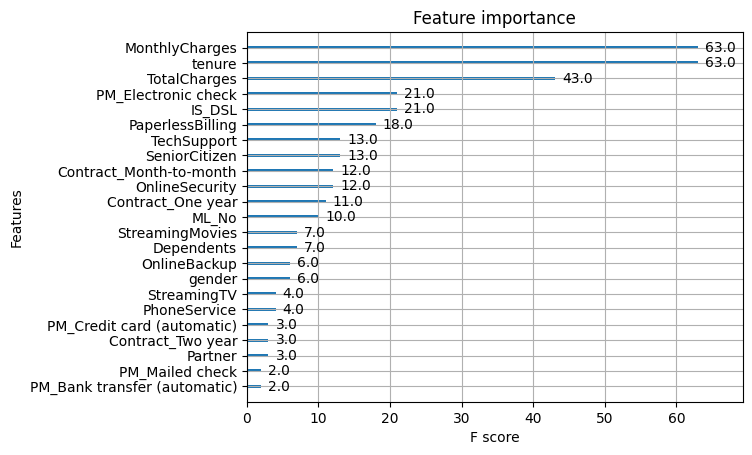

In [34]:
plot_importance(xgb_final)

In [38]:
# bayesian optimization
# Define the hyperparameter search space
pbounds = {
    "learning_rate": (0.01, 1.0),
    "n_estimators": (100, 1000),
    "max_depth": (3, 10),
    "subsample": (0.5, 1.0),
    "colsample": (0.5, 1.0),
    "gamma": (0, 5),
}


# Define the objective function for hyperparameter tuning
def xgboost_hyper_param(
    learning_rate, n_estimators, max_depth, subsample, colsample, gamma
):
    max_depth = int(max_depth)
    n_estimators = int(n_estimators)
    clf = xgb.XGBClassifier(
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        gamma=gamma,
    )
    return np.mean(cross_val_score(clf, X_train, y_train, cv=3, scoring="accuracy"))


# Run Bayesian Optimization
optimizer = BayesianOptimization(f=xgboost_hyper_param, pbounds=pbounds, random_state=1)
optimizer.maximize(init_points=5, n_iter=10)

# Get the best hyperparameters
best_hyperparameters = optimizer.max["params"]
print("Best Hyperparameters:", best_hyperparameters)

|   iter    |  target   | colsample |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | 0.7664    | 0.7085    | 3.602     | 0.01011   | 5.116     | 232.1     | 0.5462    |
| 2         | 0.7589    | 0.5931    | 1.728     | 0.4028    | 6.772     | 477.3     | 0.8426    |
| 3         | 0.7711    | 0.6022    | 4.391     | 0.03711   | 7.693     | 475.6     | 0.7793    |
| 4         | 0.748     | 0.5702    | 0.9905    | 0.8027    | 9.778     | 382.1     | 0.8462    |
| 5         | 0.7664    | 0.9382    | 4.473     | 0.09419   | 3.273     | 252.8     | 0.9391    |
| 6         | 0.7684    | 0.8088    | 3.498     | 0.09245   | 4.648     | 232.0     | 0.6739    |
| 7         | 0.7641    | 0.9375    | 4.304     | 0.7043    | 7.827     | 472.9     | 0.9175    |
| 8         | 0.758     | 1.0       | 2.027     | 0.8779    | 3.0       | 230.9     | 1.0       |
| 9         | 0.765 

In [36]:
X_train_opt = X_train[
    [
        "TotalCharges",
        "tenure",
        "Contract_Two year",
        "Contract_Month-to-month",
        "OnlineSecurity",
        "TechSupport",
        "PM_Electronic check",
        "IS_DSL",
        "Contract_One year",
        "IS_Fiber optic",
    ]
]

X_test_opt = X_test[
    [
        "TotalCharges",
        "tenure",
        "Contract_Two year",
        "Contract_Month-to-month",
        "OnlineSecurity",
        "TechSupport",
        "PM_Electronic check",
        "IS_DSL",
        "Contract_One year",
        "IS_Fiber optic",
    ]
]

model_opt = xgb.XGBClassifier(objective="multi:softmax", num_class=2)

# Training the model
model_opt.fit(X_train_opt, y_train)
y_pred_opt = model_opt.predict(X_test_opt)

# Evaluating the model
accuracy_opt = accuracy_score(y_test, y_pred_opt)
report_opt = classification_report(y_test, y_pred_opt)

In [37]:
accuracy_opt

0.7364130434782609